<a href="https://colab.research.google.com/github/atifR/Fruit_classificaiton/blob/main/classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch import nn
import torch.nn.functional as F
from torch import optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## INitializations

In [ ]:
dataset_folder = "Dataset"
project_path = "/content/drive/MyDrive/Fruit_classificaiton/Fruit_classificaiton"
batch_size = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

print (f"Settings ... \n project path \t\t {project_path} \n batch_size \t\t {batch_size} \n device \t\t {device}")

Using device: cuda
Settings ... 
 project path 		 /content/drive/MyDrive/Fruit_classificaiton/Fruit_classificaiton 
 batch_size 		 32 
 device 		 cuda


(3120, 4160, 3)


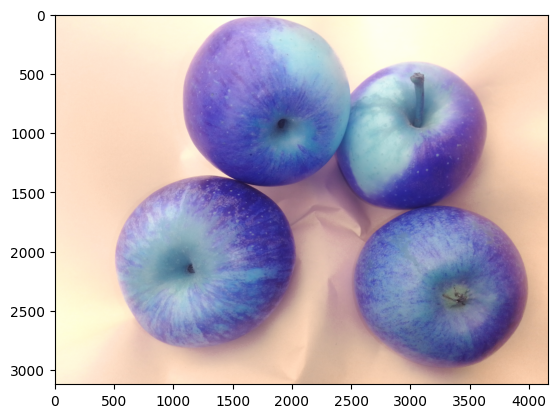

In [ ]:
image = cv2.imread(project_path + "/" + dataset_folder + '/Apple__Healthy/FreshApple (1).jpg')
import matplotlib.pyplot as plt
print(image.shape)
plt.imshow(image)


## If you want to create meta_data CSV file ...

In [ ]:

file_paths = []
for folder in os.listdir(path):
    if not folder.startswith('.') and not folder.startswith('meta_data.csv'):
        print(f'Processing {folder}...')
        for file_name in os.listdir(path + '/' + folder):
            dict = {}
            dict['id'] = 0 if "Healthy" in folder else 1
            dict['path'] = path + '/' + folder + '/' +  file_name
            dict['id_description'] = "healthy" if "Healthy" in folder else "Rotten"
            file_paths.append(dict)
print('Done, saving meta_data.csv...')
df = pd.DataFrame(file_paths)
df.to_csv(path + "/meta_data.csv",index=False )


Processing Mango__Rotten...
Processing Orange__Rotten...
Processing Jujube__Healthy...
Processing Cucumber__Rotten...
Processing Apple__Rotten...
Processing Grape__Rotten...
Processing Tomato__Rotten...
Processing Bellpepper__Healthy...
Processing Tomato__Healthy...
Processing Carrot__Healthy...
Processing Grape__Healthy...
Processing Apple__Healthy...
Processing Guava__Healthy...
Processing Potato__Healthy...
Processing Banana__Healthy...
Processing Potato__Rotten...
Processing Cucumber__Healthy...
Processing Strawberry__Healthy...
Processing Carrot__Rotten...
Processing Strawberry__Rotten...
Processing Pomegranate__Rotten...
Processing Bellpepper__Rotten...
Processing Jujube__Rotten...
Processing Guava__Rotten...
Processing Pomegranate__Healthy...
Processing Orange__Healthy...
Processing Banana__Rotten...
Processing Mango__Healthy...
Done, saving meta_data.csv...


In [ ]:
#df = pd.read_csv(project_path +"/" +  + "/meta_data.csv")
df = pd.read_csv(f"{project_path}/{dataset_folder}/meta_data.csv")
print(df.shape)
number_files = df.shape[0]
indices= np.arange(0,number_files,1)
np.random.shuffle(indices)


(29291, 3)


In [ ]:
train_ratio = 0.7
test_ratio = 0.3

train_indices = indices[:int(train_ratio * len(indices) )]
test_indices = indices[int(train_ratio * len(indices) )+1:]

print (f"trainig size {len(train_indices)}, test size {len(test_indices)}")

trainig size 20503, test size 8787


In [ ]:
class ProduceDataset(Dataset):
    def __init__(self, indices,project_path ,csv_name="meta_data.csv", transform=None):
        self.indices = indices
        self.df = pd.read_csv(csv_name)
        self.transform = transform
        self.project_path = project_path

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):

        dict = self.df.iloc[self.indices[index]]
        path = dict["path"]
        path = f"{self.project_path}/{path}"
        x =  cv2.imread(path)
        #x = read_image(path)
        if x is None: # Check if image loading failed
            print(f"Failed to load image: {dict['path']}")
            return None, None # Handle the error, e.g., skip the image
        #x = x[:3, :, :]
        if (self.transform):
            x = self.transform(x)
        y = dict["id"]

        return x,y

In [ ]:
project_path + "/"+ dataset_folder +"/meta_data.csv"



'/content/drive/MyDrive/Fruit_classificaiton/Fruit_classificaiton/Dataset/meta_data.csv'

In [ ]:
meta_data_path = project_path + "/"+ dataset_folder +"/meta_data.csv"

train_dataset = ProduceDataset(train_indices,project_path,
                               meta_data_path,transform=transforms.Compose([transforms.ToPILImage(),

                                                                            transforms.Resize((256,256)),transforms.ToTensor(),
                                                                                                   ]) )
test_dataset = ProduceDataset(test_indices,project_path,meta_data_path, transform=transforms.Compose([transforms.ToPILImage(), transforms.Resize((256,256)),
                                                                                                   transforms.ToTensor()]))

train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)



In [ ]:
df = pd.read_csv(path + "/meta_data.csv")
dict = df.iloc[0]
x =  cv2.imread( dict["path"])
print(dict)


NameError: name 'path' is not defined

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


## CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__ (self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
                                                                                                    #256,256,4
            nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
                                                                                                    #256,256,8
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
                                                                                                    #128,128,16
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
                                                                                                    #64,64,32
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
                                                                                                    #32,32,64
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
                                                                                                    #16,16,64
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
                                                                                                    #8,8,64
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
                                                                                                    #8,8,128
            nn.Flatten(),
            nn.Linear(128*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 28),
            nn.ReLU(),
            nn.Linear(28,2)
        )


    def forward(self, x):
            return self.network(x)

In [ ]:


model = CNN()
model = model.to(device)    #converting model to gpu from cpu
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3 )
print("Compiled Successfully")

Compiled Successfully


In [ ]:
import time
for epoch in range(20):
    start_time = time.time()
    for x,y in train_dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criteria(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"loss value of epoch {epoch+1} = {loss} in {epoch_time:.4f} seconds")

RuntimeError: Unsupported image file. Only jpeg and png are currently supported.

In [ ]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x,y = x.to(device), y.to(device)
            scores = model(x)
            _, predictions = scores.max(1)
            correct += (predictions == y).sum().item()
            total += predictions.size(0)
    model.train()
    return correct/total

In [ ]:
print(f"Training Accuracy is {calculate_accuracy(train_dataloader, model)*100}")

print(f"Testing Accuracy is {calculate_accuracy(test_dataloader, model)*100}")

In [ ]:
import random

import matplotlib.pyplot as plt
def show_images(images, titles, rows=4, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols]
        img = img.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format for displaying and move to CPU
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Number of images to display
num_images = 12

# Randomly select indices from the test dataset
indices = random.sample(range(len(test_data)), num_images)
images, titles = [], []

# Set the model to evaluation mode and move to the appropriate device
model.to(device)
model.eval()

# Disable gradient calculation
with torch.no_grad():
    for idx in indices:
        # Get the image and label from the test dataset
        image, label = test_data[idx]

        # Move the image to the appropriate device
        image = image.to(device)

        images.append(image.cpu())  # Append the image (moved back to CPU for display)

        # Get the model's prediction
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)

        # Get class names
        actual_class = dataset.classes[label]
        predicted_class = dataset.classes[predicted.item()]

        # Create a title with predicted and actual class names
        titles.append(f'Pred: {predicted_class}\nActual: {actual_class}')

# Display the images with titles
show_images(images, titles)